In [1]:
import pandas as pd
import pytz, datetime
import pytz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

from sklearn import metrics


MOVING_AVERAGE_WINDOW_MUON = 12
MOVING_AVERAGE_WINDOW_GDAS = 12

In [2]:
# path='/home/jesus/python/'
gdas = pd.read_csv('teffDatatotal2021.csv',delimiter=r",+", skiprows=1, names=['id','date','teff', 'ts', 'ps'],lineterminator='\n')
gdas .drop(columns=['id'])

<ipython-input-2-cac747d7c1e0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  gdas = pd.read_csv('teffDatatotal2021.csv',delimiter=r",+", skiprows=1, names=['id','date','teff', 'ts', 'ps'],lineterminator='\n')


,date,teff,ts,ps
0,2021-04-22 00:00:00,258.678514,295.676751,1003.974548
1,2021-04-22 03:00:00,258.485871,294.354389,1002.536988
2,2021-04-22 06:00:00,258.237134,293.285440,1000.667368
3,2021-04-22 09:00:00,257.945635,292.217840,1001.476468
4,2021-04-22 12:00:00,257.871836,296.544471,1002.119468
...,...,...,...,...
308,2021-05-30 12:00:00,255.438747,289.723518,1010.628248
309,2021-05-30 15:00:00,255.766183,296.826410,1010.116648
310,2021-05-30 18:00:00,255.804288,298.534678,1007.571288
311,2021-05-30 21:00:00,255.692003,292.299007,1007.438188


In [3]:
gdas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      313 non-null    int64  
 1   date    313 non-null    object 
 2   teff    313 non-null    float64
 3   ts      313 non-null    float64
 4   ps      313 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 12.4+ KB


In [4]:
gdas['date']=pd.to_datetime(gdas.date, format='%Y-%m-%d %H:%M:%S',utc=True)

gdas.set_index(['date'],drop=True, inplace=True)


In [5]:
py = pd.read_csv('total_de_muones.csv')
py['datetime']=pd.to_datetime(py.Time,format='%Y-%m-%d %H:%M:%S',utc=True)
py.set_index(['datetime'],drop=True, inplace=True)

In [6]:
py.head()

,Time,sumaTodos
datetime,,
2021-04-22 11:30:00+00:00,2021-04-22 11:30:00,0
2021-04-22 12:00:00+00:00,2021-04-22 12:00:00,0
2021-04-22 12:30:00+00:00,2021-04-22 12:30:00,0
2021-04-22 13:00:00+00:00,2021-04-22 13:00:00,0
2021-04-22 13:30:00+00:00,2021-04-22 13:30:00,0


In [7]:
py=py.resample('H').sum()

In [8]:
flagPy=np.logical_and(py.index>="2021-04-23",py.index<="2021-05-31")
py=py[flagPy]
#sup=np.percentile(py['sumaTodos'].values, 95)                
#inf=np.percentile(py['sumaTodos'].values,5)  
#flag=np.logical_and(py['sumaTodos'].values<sup,py['sumaTodos'].values>inf)
"""¿Qué ese ese valor 150 000 y porque ese un límite?"""

flag=py['sumaTodos'].values>150000
py=py[flag]
sup=np.max(py['sumaTodos'].values) #Para el rango               
inf=np.min(py['sumaTodos'].values) #Para el rango  

In [9]:
py.tail()

,sumaTodos
datetime,
2021-05-30 20:00:00+00:00,175178
2021-05-30 21:00:00+00:00,177836
2021-05-30 22:00:00+00:00,179548
2021-05-30 23:00:00+00:00,177782
2021-05-31 00:00:00+00:00,180239


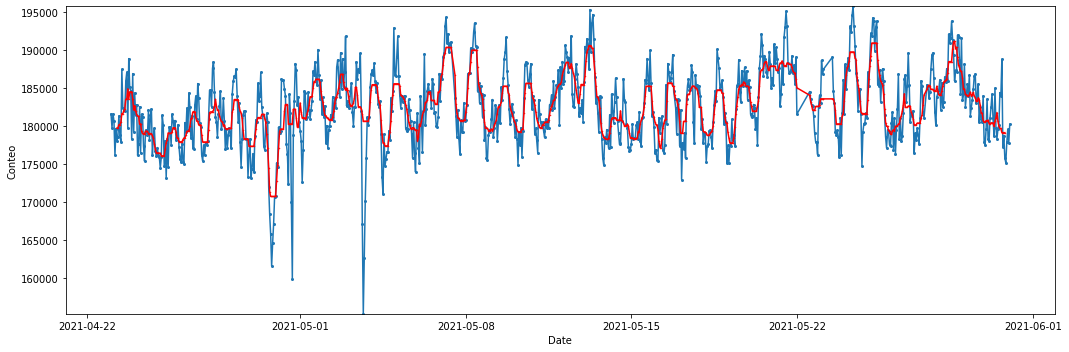

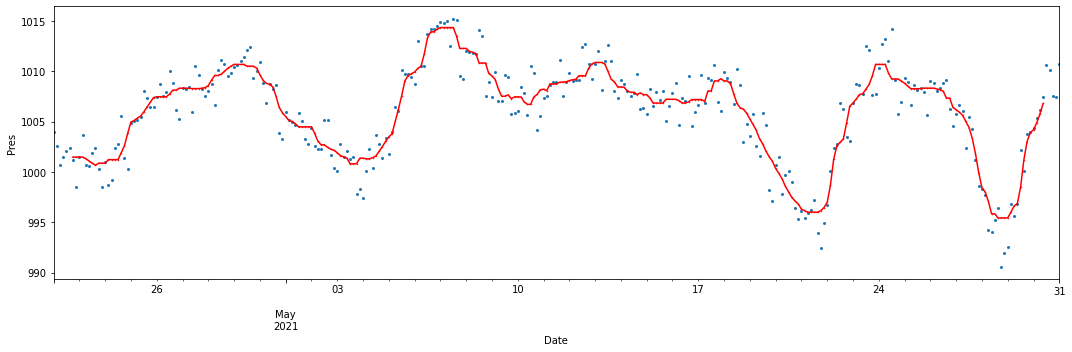

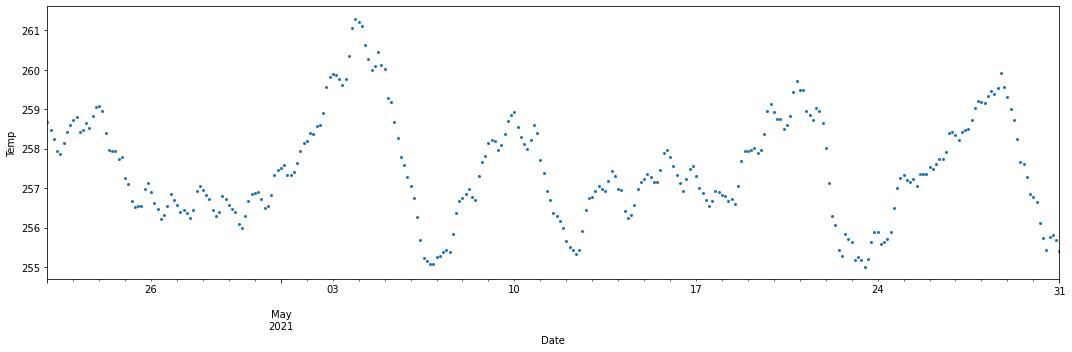

In [10]:
fig, axes = plt.subplots(1,1, figsize=(15,5), sharex=True)

py['sumaTodos'].plot(subplots=True,marker='.',ylim=(inf,sup),markersize=4, linestyle='-', ax=axes)

"""Moving average"""
py['sumaTodos_med']=py['sumaTodos'].rolling(MOVING_AVERAGE_WINDOW_MUON,center=True).median()
"""Moving average"""

py['sumaTodos_med'].plot(subplots=True,marker='.',ylim=(inf,sup),markersize=1, color='red',linestyle='-', ax=axes)

axes.set_ylabel('Conteo')
axes.set_xlabel('Date')
plt.tight_layout()


fig, axes = plt.subplots(1,1, figsize=(15,5), sharex=True)
gdas['ps'].plot(subplots=True,marker='.', markersize=4, linestyle='None', ax=axes)

"""Moving average GDAS"""
gdas['ps_med']=gdas['ps'].rolling(MOVING_AVERAGE_WINDOW_GDAS,center=True).median()
"""Moving average"""

gdas['ps_med'].plot(subplots=True,marker='.',markersize=1, color='red',linestyle='-', ax=axes)

axes.set_ylabel('Pres')
axes.set_xlabel('Date')
plt.tight_layout()

#plt.savefig('pngs/GDASTefSerieCrudaPress.png')
fig, axes = plt.subplots(1,1, figsize=(15,5), sharex=True)
gdas['teff'].plot(subplots=True,marker='.', markersize=4, linestyle='None', ax=axes)
axes.set_ylabel('Temp')
axes.set_xlabel('Date')
plt.tight_layout()

In [11]:
countsClean=py

In [12]:
combined = gdas.join(countsClean['sumaTodos'], how='outer')
combined=combined.drop(combined.index[0])

In [13]:
flag1=np.logical_and(combined.index>="2021-04-23",combined.index<="2021-05-31")

In [14]:
Im=combined['sumaTodos'].dropna().mean()
combined['dIoIm']=(combined['sumaTodos'][flag1]-Im)/(Im)*100
P0=combined['ps'][flag1].dropna().mean()
combined['dP']=(combined['ps'][flag1]-P0)

In [15]:
Tg=combined['teff'][flag1].dropna().mean()
combined['dTg']=(combined['teff'][flag1]-Tg)

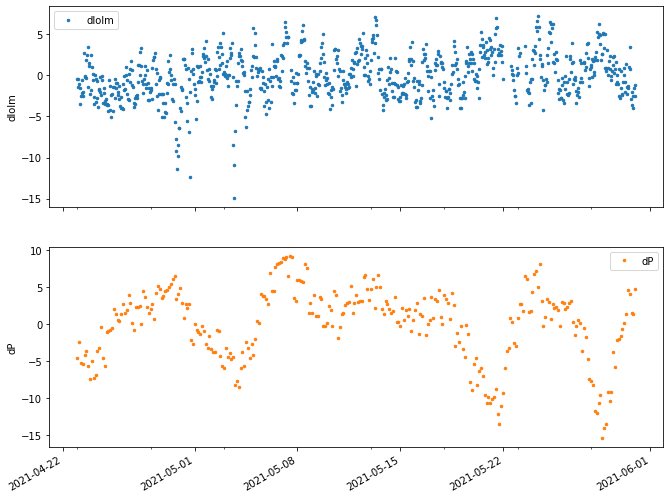

In [16]:
var = ['dIoIm', 'dP']
axes = combined[var][flag1].plot(marker='.', markersize=5 , linestyle='None', figsize=(11, 9), subplots=True)
for ax,v in zip(axes,var):
    ax.set_ylabel(v)

In [17]:
combined=combined[flag1]

In [18]:
var='dIoIm'
distance = 1.5 * (np.percentile(combined[var][~np.isnan(combined[var])], 75) - np.percentile(combined[var][~np.isnan(combined[var])], 25))
fA=combined[var]< distance + np.percentile(combined[var][~np.isnan(combined[var])], 75)
fB=combined[var] > np.percentile(combined[var][~np.isnan(combined[var])], 25) - distance
fC=np.isnan(combined[var]) 
combinedNew=combined[np.logical_or(np.logical_and(fA,fB),fC)]

In [19]:
flagNa=~np.isnan(combinedNew['dIoIm'].values)

In [20]:
combinedNew = combinedNew.apply(
    pd.Series.interpolate, 
    args=('index',) 
)

In [21]:
combinedNew=combinedNew[flagNa]

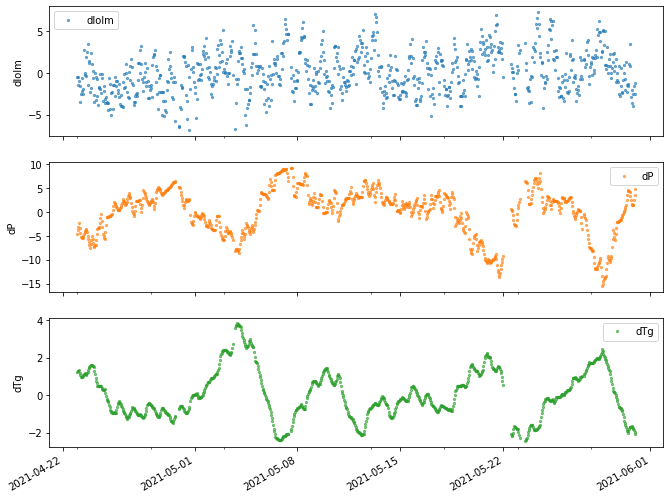

In [22]:
var = ['dIoIm', 'dP','dTg']
axes = combinedNew[var].plot(marker='.',markersize=4.5, linestyle='None', alpha=0.6, figsize=(11, 9), subplots=True)
#axes = combined[var].plot(marker='.', alpha=1, linestyle='None', figsize=(11, 9), subplots=True)
for ax,v in zip(axes,var):
    ax.set_ylabel(v)

In [23]:
combinedNewHour=combinedNew.resample('H').mean()

In [24]:
combinedNewHour['dIoIm']

2021-04-23 00:00:00+00:00   -0.496489
2021-04-23 01:00:00+00:00   -1.482855
2021-04-23 02:00:00+00:00   -0.495393
2021-04-23 03:00:00+00:00   -1.014879
2021-04-23 04:00:00+00:00   -3.482438
                               ...   
2021-05-30 20:00:00+00:00   -4.005760
2021-05-30 21:00:00+00:00   -2.549226
2021-05-30 22:00:00+00:00   -1.611082
2021-05-30 23:00:00+00:00   -2.578817
2021-05-31 00:00:00+00:00   -1.232427
Freq: H, Name: dIoIm, Length: 913, dtype: float64

In [25]:
combinedNewHour=combinedNewHour.dropna()

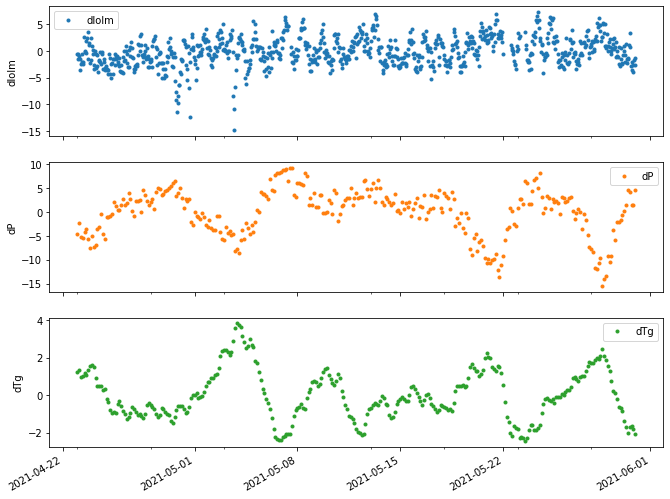

In [26]:
var = ['dIoIm', 'dP','dTg']
# axes = combinedNewHour[var].plot(marker='.',markersize=5, linestyle='None', alpha=1.6, figsize=(11, 9), subplots=True)
axes = combined[var].plot(marker='.', alpha=1, linestyle='None', figsize=(11, 9), subplots=True)
for ax,v in zip(axes,var):
    ax.set_ylabel(v)

In [27]:
lm = LinearRegression() 
X=combinedNewHour['dP'].values.reshape(-1,1)
Y=combinedNewHour['dIoIm']

In [28]:
lm.fit(X,Y)

LinearRegression()

In [29]:
print(lm.intercept_)
print(lm.coef_)

0.10593646576850797
[-0.07060702]


In [30]:
pred=lm.predict(X)
print(np.sum(np.square(np.square(pred - Y))))

97482.41730227173


In [31]:
print("R-squared value of this fit:",round(metrics.r2_score(Y,pred),3))

R-squared value of this fit: 0.018


In [32]:
combinedNewHour['dP'].corr(combinedNewHour['dIoIm'])

-0.1348684346784754

/home/ponci_pop/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dIoIm'>

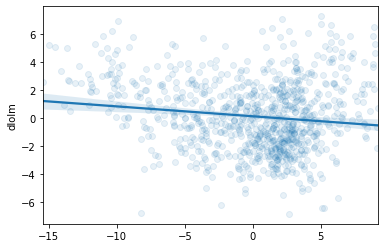

In [33]:
sns.regplot(combinedNewHour['dP'].values.reshape(-1,1),combinedNewHour['dIoIm'],scatter_kws={'alpha':0.1})

In [34]:
lm.coef_

array([-0.07060702])

In [35]:
combinedNewHour['dIoImPC']=combinedNewHour['dIoIm']-lm.coef_*combinedNewHour['dP']

/home/ponci_pop/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dIoImPC'>

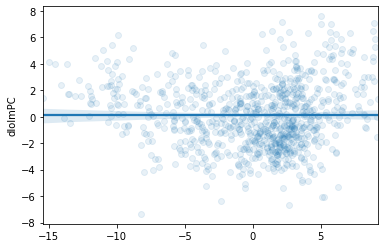

In [36]:
sns.regplot(combinedNewHour['dP'].values.reshape(-1,1),combinedNewHour['dIoImPC'],scatter_kws={'alpha':0.1})

In [37]:
combinedNewHour['dP'].corr(combinedNewHour['dIoImPC'])

-3.785501308523201e-17

0.10602302182933065
[-0.00251859]
97701.23585308013
[-0.00251859]
/home/ponci_pop/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ponci_pop/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dIoImPTC'>

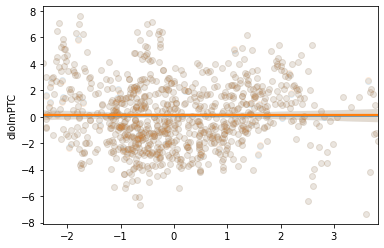

In [38]:
lmT = LinearRegression() 
XT=combinedNewHour['dTg'].values.reshape(-1,1)
YT=combinedNewHour['dIoImPC']
lmT.fit(XT,YT)
print(lmT.intercept_)
print(lmT.coef_)
predT=lmT.predict(X)
print(np.sum(np.square(np.square(predT - YT))))
print(lmT.coef_)
#combinedNewHour['dIoImPC']=combinedNewHour['dIoIm']-pred
combinedNewHour['dIoImPTC']=combinedNewHour['dIoImPC']-lmT.coef_*combinedNewHour['dTg']
sns.regplot(combinedNewHour['dTg'].values.reshape(-1,1),combinedNewHour['dIoImPC'],scatter_kws={'alpha':0.1})
#plt.savefig('pngs/GDASTefscatterdTgvsDIoImPC.png')

sns.regplot(combinedNewHour['dTg'].values.reshape(-1,1),combinedNewHour['dIoImPTC'],scatter_kws={'alpha':0.1})

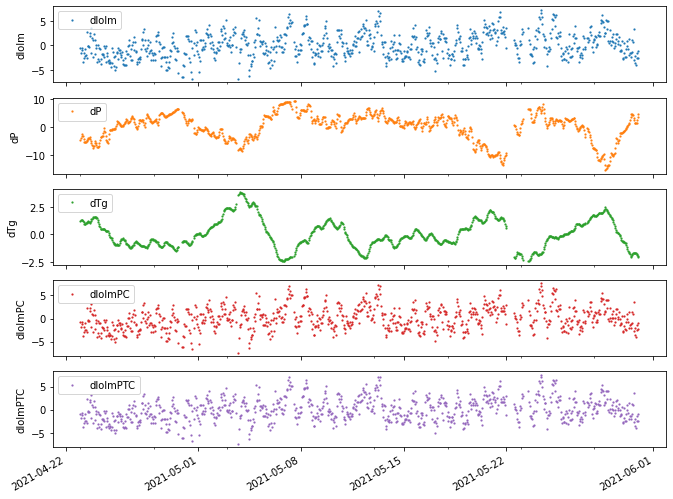

In [39]:
var = ['dIoIm', 'dP','dTg','dIoImPC','dIoImPTC']
axes = combinedNewHour[var].plot(marker='.',markersize=2.5, linestyle='None', alpha=0.9, figsize=(11, 9), subplots=True)
#axes = combined[var].plot(marker='.', alpha=1, linestyle='None', figsize=(11, 9), subplots=True)
for ax,v in zip(axes,var):
    ax.set_ylabel(v)

In [40]:
combinedNewHour.head()

,id,teff,ts,ps,ps_med,sumaTodos,dIoIm,dP,dTg,dIoImPC,dIoImPTC
2021-04-23 00:00:00+00:00,8.000000,258.722936,295.225073,1001.480488,1001.478478,181582.0,-0.496489,-4.535946,1.255182,-0.816758,-0.813597
2021-04-23 01:00:00+00:00,8.333333,258.747002,294.794159,1002.202508,1001.478478,179782.0,-1.482855,-3.813926,1.279249,-1.752145,-1.748923
2021-04-23 02:00:00+00:00,8.666667,258.771069,294.363245,1002.924528,1001.478478,181584.0,-0.495393,-3.091906,1.303315,-0.713703,-0.710421
2021-04-23 03:00:00+00:00,9.000000,258.795135,293.932332,1003.646548,1001.478478,180636.0,-1.014879,-2.369887,1.327381,-1.182210,-1.178866
2021-04-23 04:00:00+00:00,9.333333,258.670329,293.369122,1002.670394,1001.424681,176133.0,-3.482438,-3.346040,1.202575,-3.718692,-3.715663


In [41]:
combinedNewHour.tail()

,id,teff,ts,ps,ps_med,sumaTodos,dIoIm,dP,dTg,dIoImPC,dIoImPTC
2021-05-30 20:00:00+00:00,310.666667,255.729431,294.377564,1007.482555,1006.808718,175178.0,-4.005760,1.466120,-1.738323,-3.902242,-3.906620
2021-05-30 21:00:00+00:00,311.000000,255.692003,292.299007,1007.438188,1006.808718,177836.0,-2.549226,1.421754,-1.775751,-2.448840,-2.453313
2021-05-30 22:00:00+00:00,311.333333,255.593519,291.624507,1008.523408,1006.808718,179548.0,-1.611082,2.506974,-1.874235,-1.434073,-1.438793
2021-05-30 23:00:00+00:00,311.666667,255.495035,290.950007,1009.608628,1006.808718,177782.0,-2.578817,3.592194,-1.972719,-2.325183,-2.330152
2021-05-31 00:00:00+00:00,312.000000,255.396551,290.275507,1010.693848,1006.808718,180239.0,-1.232427,4.677413,-2.071203,-0.902169,-0.907386


In [42]:
combinedNewHour['Year'] =combinedNewHour.index.year
combinedNewHour['Month'] = combinedNewHour.index.month
combinedNewHour['day'] = combinedNewHour.index.day
combinedNewHour['hour'] = combinedNewHour.index.hour
combinedNewHour['hour3'] = combinedNewHour.index.hour-3

Text(0, 0.5, 'dIoImPTC')

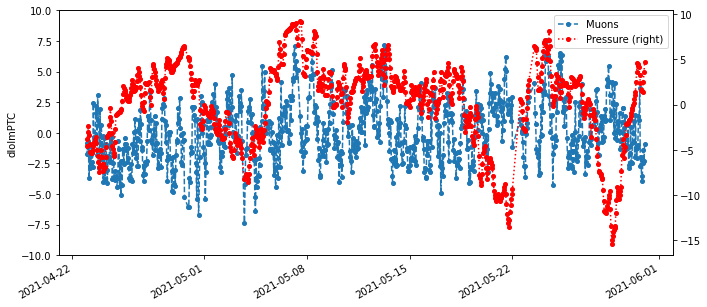

In [43]:
ax = plt.gca()
combinedNewHour['dIoImPTC'].plot(marker='.',markersize=8,ylim=(-10,10), linestyle='dashed',legend=True,label='Muons',alpha=1, figsize=(11, 5),ax=ax)
ax_secondary =combinedNewHour['dP'].plot(ax=ax,marker='.',markersize=8, label='Pressure', linestyle='dotted',
    legend=True, secondary_y=True, color='r')
ax.set_ylabel('dIoImPTC')

Text(0, 0.5, 'dIoImPTC')

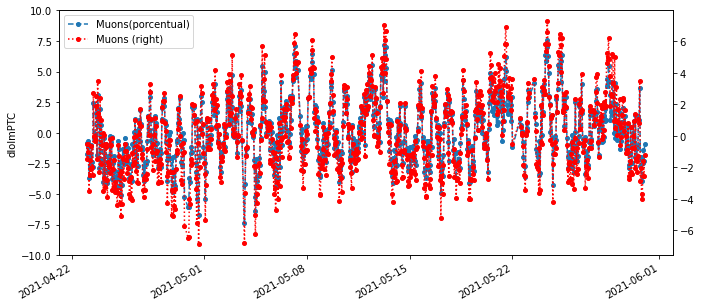

In [44]:
ax = plt.gca()
combinedNewHour['dIoImPTC'].plot(marker='.',markersize=8,ylim=(-10,10), linestyle='dashed',legend=True,label='Muons(porcentual)',alpha=1, figsize=(11, 5),ax=ax)
ax_secondary =combinedNewHour['dIoIm'].plot(ax=ax,marker='.',markersize=8, label='Muons', linestyle='dotted',
    legend=True, secondary_y=True, color='r')
ax.set_ylabel('dIoImPTC')